In [ ]:
%%capture
!pip install transformers accelerate bitsandbytes sentencepiece protobuf tabulate
!pip install git+https://github.com/run-llama/llama_index

## You can access the data [here](https://drive.google.com/drive/folders/14sOGD4-cFlmcG1IkTTQRZI3H-eyGSGvM?usp=sharing)

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
large_data_path = "/content/drive/MyDrive/large_table.csv"
large_data = pd.read_csv(large_data_path)
large_data_hard_path = "/content/drive/MyDrive/large_table_hard.csv"
large_data_hard = pd.read_csv(large_data_hard_path, index_col=0)
medium_data_path = "/content/drive/MyDrive/medium_table.csv"
medium_data = pd.read_csv(medium_data_path, index_col=0)
small_data_path = "/content/drive/MyDrive/small_table.csv"
small_data = pd.read_csv(small_data_path, index_col=0)

question_small = """What is the employee count for each race in each department in the dataset?"""
question_medium = """What is the average engagement score for males and females for each title in the dataset?"""
question_large = """What is the employees count and	avgerage training duration for each location in the dataset?"""
question_large_hard = """For each combination of education level and job function description in recruitment data, how many distinct applicants are there with more than 5 years of experience?"""

Mounted at /content/drive


In [ ]:
from transformers import AutoTokenizer, LlamaForCausalLM
from llama_index.llms.huggingface import (
  HuggingFaceLLM, PromptTemplate
)
from transformers import BitsAndBytesConfig
import torch

model_path = "codellama/CodeLlama-7b-Instruct-hf"
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    load_in_8bit_fp32_cpu_offload=True
    )

model = HuggingFaceLLM(
    model_name = model_path,
    tokenizer_name = model_path,
    query_wrapper_prompt = PromptTemplate("{query_str}"),
    # context_window=3900,
    max_new_tokens=1024,
    model_kwargs = {"quantization_config": quantization_config},
    # tokenizer_kwargs={},
    # generate_kwargs = {"temperature": 0.2, "top_k": 15, "top_p": 0.95},
    device_map = "auto",
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/646 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

In [ ]:
def inference(prompt: str):
    response = model.complete(prompt).text.strip()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    return response

In [ ]:
prompt_vega = '''
Generate an insightful Vega-Lite visualization that effectively illustrates the data and addresses the user's query.
Ensure the Vega-Lite specification accurately represents the provided data and makes the visualization intuitive and informative.
Pay meticulous attention to the specification's structure, including encoding, mark type, and any data transformations.
Enhance the visualization with a descriptive title and a succinct yet informative description to facilitate understanding.

Question: {}

Data Sample: {}

Vega-Lite json string:
'''


prompt_code = '''
Generate a Python function to effectively illustrate the data and answer the user's question. The function should take in an input dataframe and return a matplotlib plot.
  Data Sample: {}
  Question: {}

Python Code:
'''

In [ ]:
import altair as alt
import json
import pandas as pd

def plot_vega_lite_chart(vega_lite_spec, data=None, width=600, height=400, tooltip=True, max_bars=25, top_bars=15):
    vega_lite_spec_dict = json.loads(vega_lite_spec)

    # Set width and height
    vega_lite_spec_dict["width"] = width
    vega_lite_spec_dict["height"] = height

    if data is not None:
        vega_lite_spec_dict["data"]["values"] = data.to_dict(orient='records')

        # if bar plot
        if vega_lite_spec_dict["mark"] == "bar":
            for var in vega_lite_spec_dict['encoding'].keys():
                column = vega_lite_spec_dict['encoding'][var]['field']
                uniques = data[column].unique().tolist()
                dtype = data[column].dtype

                # Set scale domain for non-numeric columns
                if not pd.api.types.is_numeric_dtype(dtype):
                    try:
                        vega_lite_spec_dict['encoding'][var]['scale']['domain'] = uniques
                    except:
                        pass

                    # select top bars if exceeded the max bars
                    if var == 'x' and len(uniques) >= max_bars:
                        vega_lite_spec_dict['encoding'][var]["sort"] = "-y"
                        # Add a window transform to select only top k bars
                        vega_lite_spec_dict["transform"] = [
                            {
                                "window": [{"op": "row_number", "as": "rank"}],
                                "sort": [{"field": "-y", "order": "descending"}]
                            },
                            {
                                "filter": {"field": "rank", "lte": max_bars}
                            }
                        ]
                        vega_lite_spec_dict["encoding"]["x"]["axis"] = {
                                  "labelAngle": 45
                              }
                else:
                    # Remove scale domain for numeric columns
                    try:
                        del vega_lite_spec_dict['encoding'][var]['scale']['domain']
                    except:
                        pass

    # Configure tooltip
    if tooltip:
        vega_lite_spec_dict.setdefault("encoding", {})["tooltip"] = [{"field": field, "type": "nominal"} for field in data.columns]


    vega_lite_spec_str = json.dumps(vega_lite_spec_dict)

    stat_chart = alt.Chart.from_json(vega_lite_spec_str)
    interactive_chart = alt.Chart.from_json(vega_lite_spec_str).interactive()

    return stat_chart, interactive_chart

# Inference

In [ ]:
#viga-lite
# %%time
# large_data_response = inference(
#       prompt_vega.format(
#             large_data.sample(10).to_dict(),
#             question_large
#             )
#       )

# large_data_hard_response = inference(
#       prompt_vega.format(
#             large_data_hard.sample(10).to_dict(),
#             question_large_hard
#             )
#       )

# medium_data_response = inference(
#       prompt_vega.format(
#             medium_data.sample(10).to_dict(),
#             question_medium
#             )
#       )

# small_data_response = inference(
#       prompt_vega.format(
#             small_data.sample(10).to_dict(),
#             question_small
#             )
#       )

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
# It shows only top k bars, because number of bars exceeded the max bars
stat_chart, interactive_chart = plot_vega_lite_chart(large_data_response, large_data)
stat_chart

alt.Chart(...)

In [ ]:
interactive_chart

In [ ]:
# You can hover to show more details
stat_chart, interactive_chart = plot_vega_lite_chart(large_data_hard_response, large_data_hard)
stat_chart

alt.Chart(...)

In [ ]:
interactive_chart

alt.Chart(...)

In [ ]:
stat_chart, interactive_chart = plot_vega_lite_chart(medium_data_response, medium_data)
stat_chart

In [ ]:
interactive_chart

alt.Chart(...)

In [ ]:
stat_chart, interactive_chart = plot_vega_lite_chart(small_data_response, small_data)
stat_chart

alt.Chart(...)

In [ ]:
interactive_chart

In [ ]:
# #python code
# %%time
# large_data_response_code = inference(
#       prompt_code.format(
#             large_data.sample(10).to_dict(),
#             question_large
#             )
#       )

# large_hard_data_response_code = inference(
#       prompt_code.format(
#             large_data_hard.sample(10).to_dict(),
#             question_large_hard
#             )
#       )

# small_data_response_code = inference(
#       prompt_code.format(
#             small_data.sample(10).to_dict(),
#             question_small
#             )
#       )

# medium_data_response_code = inference(
#       prompt_code.format(
#             medium_data.sample(10).to_dict(),
#             question_medium
#             )
#       )

In [ ]:
plot_vega_lite_chart(small_data_response, small_data)

In [ ]:
print(small_data_response_code)

import pandas as pd
import matplotlib.pyplot as plt

def plot_race_department(df):
    # Create a bar plot of the employee count for each race in each department
    plt.bar(df['departmenttype'], df['Employee_Count'], label='Employee Count')
    plt.xlabel('Department')
    plt.ylabel('Employee Count')
    plt.title('Employee Count by Department and Race')
    plt.legend()
    plt.show()

# Test the function
df = pd.read_csv('data.csv')
plot_race_department(df)


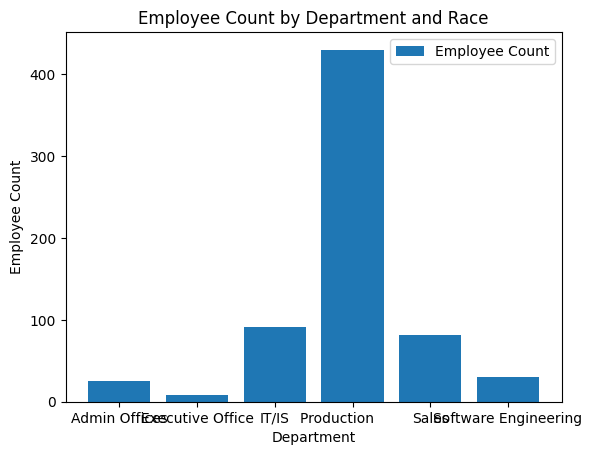

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_race_department(df):
    # Create a bar plot of the employee count for each race in each department
    plt.bar(df['departmenttype'], df['Employee_Count'], label='Employee Count')
    plt.xlabel('Department')
    plt.ylabel('Employee Count')
    plt.title('Employee Count by Department and Race')
    plt.legend()
    plt.show()

plot_race_department(small_data)

##Medium

In [ ]:
plot_vega_lite_chart(medium_data_response, medium_data)

alt.Chart(...)

In [ ]:
print(medium_data_response_code)

import pandas as pd
import matplotlib.pyplot as plt

def plot_avg_engagement_score(df):
    # Create a new dataframe with only the columns we need
    df_avg_engagement_score = df[['title', 'gendercode', 'avg_engagement_score']]

    # Group the dataframe by title and gendercode
    df_avg_engagement_score_grouped = df_avg_engagement_score.groupby(['title', 'gendercode'])

    # Calculate the average engagement score for each group
    df_avg_engagement_score_grouped_avg = df_avg_engagement_score_grouped.mean()

    # Create a new dataframe with only the average engagement score for each title and gendercode
    df_avg_engagement_score_grouped_avg_only = df_avg_engagement_score_grouped_avg.reset_index()

    # Create a new dataframe with only the average engagement score for each title
    df_avg_engagement_score_grouped_avg_only_title = df_avg_engagement_score_grouped_avg_only.groupby('title')

    # Calculate the average engagement score for each title
    df_avg_engagement_score_gro

In [ ]:
print(large_hard_data_response)

{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "data": {
    "values": [
      {
        "Education_Level": "Bachelor's Degree",
        "Job_Function_Description": "Administrator",
        "Applicant_Count": 9
      },
      {
        "Education_Level": "Bachelor's Degree",
        "Job_Function_Description": "Labor",
        "Applicant_Count": 1
      },
      {
        "Education_Level": "Bachelor's Degree",
        "Job_Function_Description": "Driller",
        "Applicant_Count": 8
      },
      {
        "Education_Level": "Bachelor's Degree",
        "Job_Function_Description": "Planner",
        "Applicant_Count": 2
      },
      {
        "Education_Level": "Bachelor's Degree",
        "Job_Function_Description": "Tower Hand",
        "Applicant_Count": 4
      },
      {
        "Education_Level": "Bachelor's Degree",
        "Job_Function_Description": "Groundman",
        "Applicant_Count": 8
      },
      {
        "Education_Level": "Bachelor's Degr

In [ ]:
# chart = plot_vega_lite_chart(large_hard_data_response, large_data_hard)
# chart

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

# def plot_education_level_job_function_description(df):
#     # Create a new dataframe with only the columns we need
#     df_education_level_job_function_description = df[['Education_Level', 'Job_Function_Description', 'Applicant_Count']]

#     # Group the dataframe by education level and job function description
#     df_education_level_job_function_description_grouped = df_education_level_job_function_description.groupby(['Education_Level', 'Job_Function_Description'])

#     # Create a new dataframe with the number of distinct applicants with more than 5 years of experience for each combination of education level and job function description
#     df_education_level_job_function_description_grouped_distinct_applicants = df_education_level_job_function_description_grouped['Applicant_Count'].apply(lambda x: x.nunique())

#     # Plot the results
#     plt.figure(figsize=(10, 6))
#     plt.bar(df_education_level_job_function_description_grouped_distinct_applicants.index, df_education_level_job_function_description_grouped_distinct_applicants.values)
#     plt.xlabel('Education Level')
#     plt.ylabel('Number of Distinct Applicants with More Than 5 Years of Experience')
#     plt.title('Distinct Applicants with More Than 5 Years of Experience by Education Level and Job Function Description')
#     plt.show()

# plot_education_level_job_function_description(large_data_hard)